# RNN (Time Series)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

Our dataset has a feature and includes monthly sales data of the Federal Reserve Bank in the United States, related to clothing and clothing accessories. It is not healthy to build a model with the information of a single feature, because there are many factors affecting the sale. Here, we will build a model with a single feature in order to learn the subject.

When we read only the dataset without running the hyperparameters, we see data at the level of date and million dollars. We converted date to date format with __parse_dates=True__ and indexed date column with __index_col='DATE'__. When working with timeseries, the time feature is indexed:

In [2]:
df = pd.read_csv('/Users/onurhanaydin/Desktop/Data Science/DL/DL-S10-Univariate Time Series with RNN/RSCCASN.csv',
                 index_col='DATE',
                 parse_dates=True
                )

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [5]:
df.columns = ['Sales']

Although sales follow the same trend, we see an increase in general over time. Our aim will be to predict the next sales trend with the forecast (only the relationship between time and sales is looked at without taking into account other external factors):

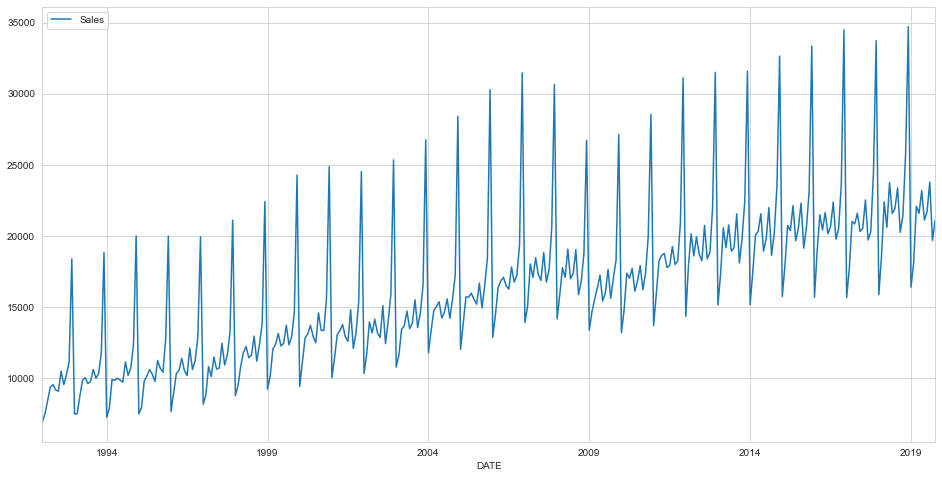

In [6]:
df.plot(figsize=(16,8));

## Preprocessing of Data

### Train Test Split

Our data is a monthly data, so a period is completed every 12 months. So it will complete a period in 12 lines. To check for val_los in the model, length=12 will be set.

In [7]:
len(df)

334

We need to get the length of the test data more than the length of the sequences. That's why we chose test_size as 2 times the length of the sequence and set it to 24:

In [8]:
test_size = 24

We subtracted the length of test_size from the length of df and got the number 310. Starting from line 310, we will divide our data into train and test:

In [9]:
test_ind = len(df)- test_size
test_ind

310

We will have train before line 310 and test data after line 310 (test data must be taken from the end in Timeseries data):

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-06-01,20322
2017-07-01,20535
2017-08-01,22536


In [12]:
test

,Sales
DATE,
2017-11-01,24438
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919


### Scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

Since we are working on a single feature, there is no X_train, y_train data. Both X and y are in the same feature.

In [15]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
#help(TimeseriesGenerator)

Help on class TimeseriesGenerator in module keras.preprocessing.sequence:

class TimeseriesGenerator(keras_preprocessing.sequence.TimeseriesGenerator, keras.utils.data_utils.Sequence)
 |  TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)
 |  
 |  Utility class for generating batches of temporal data.
 |  
 |  This class takes in a sequence of data-points gathered at
 |  equal intervals, along with time series parameters such as
 |  stride, length of history, etc., to produce batches for
 |  training/validation.
 |  # Arguments
 |      data: Indexable generator (such as list or Numpy array)
 |          containing consecutive data points (timesteps).
 |          The data should be at 2D, and axis 0 is expected
 |          to be the time dimension.
 |      targets: Targets corresponding to timesteps in `data`.
 |          It should have same length as `data`.
 |      length: Length of the outp

We set length=12 because of monthly periods. Choosing batch_size=1 is more advantageous because the data is small. We gave train data scaled into TimeseriesGenerator, and again scaled train data as target.

There is also a __shuffle=False__ parameter in the TimeseriesGenerator. This parameter was True by default in ANN and CNN, but False here. Because ordering is important in these data.

In [17]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

Subtracting 12 from 310 data, 298 generators were produced since batch_size=1. (We subtracted 12 because he couldn't do the last 12) :

It will take 12 lines, guess the 13th line, shift one line and repeat the same process until the end.

In [18]:
len(generator)

298

The first element of the Generator has 12 data, and according to these, it will predict the 13th element at the bottom:

In [19]:
generator[0]

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [20]:
X, y = generator[0]

In [21]:
print(f'Given Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


## Modelling

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

Instead of manually typing how many features there are, we defined a variable below so that when we need to specify the number of features, let's use this variable directly:

In [23]:
n_features = train_scaled.shape[1]

We have defined two hidden layers to the model. There are 100 neurons in the first hidden layer, the activation function is tanh (default value in LSTM).

__return_sequences=True -->__ When more than one layer is installed in the model, it can send the appropriate data type to the next layer as a sequence (let a series go to the next layer).

__input_shape = (length, n_features) -->__ The length we set and how many features there are.

__model.add(Dense(1)) -->__ 1 could have been replaced with n_features.

In [24]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

2022-08-23 15:20:54.517855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


The model built with LSTM has 4 times more parameters than the model built on simple RNN. Below are the formulas for calculating the number of parameters:

In [26]:
# params = 4 * ((size_of_input + 1) * size_of_output + size_of_output^2)
4 * ((1+1)*100+(100**2))

40800

In [27]:
4 * ((100+1)*50+(50**2))

30200

### EarlyStopping and Validation Generator

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

We need to generate validation data for EarlyStop. As we produced the train data, we created the validation data by giving the test data to the TimeseriesGenerator and specifying the length and batch_size:

In [30]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

We had 24 rows in the test data. Since the length is 12, it created 12 generators:

In [31]:
len(validation_generator)

12

In [32]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
298/298 [==============================] - 10s 19ms/step - loss: 0.0230 - val_loss: 0.0352
Epoch 2/20
298/298 [==============================] - 5s 18ms/step - loss: 0.0205 - val_loss: 0.0366
Epoch 3/20
298/298 [==============================] - 5s 17ms/step - loss: 0.0203 - val_loss: 0.0257
Epoch 4/20
298/298 [==============================] - 5s 17ms/step - loss: 0.0175 - val_loss: 0.0226
Epoch 5/20
298/298 [==============================] - 5s 17ms/step - loss: 0.0174 - val_loss: 0.0256
Epoch 6/20
298/298 [==============================] - 4s 15ms/step - loss: 0.0171 - val_loss: 0.0313
Epoch 7/20
298/298 [==============================] - 5s 15ms/step - loss: 0.0159 - val_loss: 0.0281
Epoch 8/20
298/298 [==============================] - 4s 15ms/step - loss: 0.0152 - val_loss: 0.0335
Epoch 9/20
298/298 [==============================] - 5s 17ms/step - loss: 0.0147 - val_loss: 0.0220
Epoch 10/20
298/298 [==============================] - 5s 17ms/step - loss: 0.0138 - val_l

<AxesSubplot:>

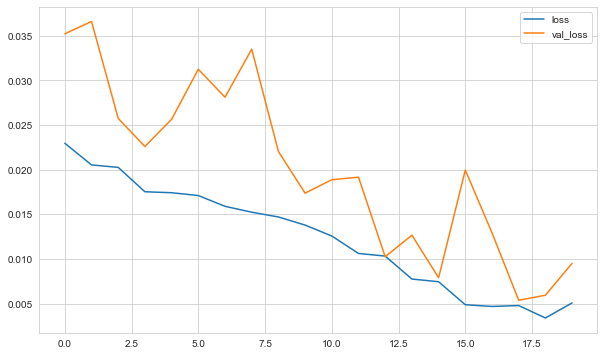

In [33]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

## Evaluate on Test Data

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [35]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

__Forecast__ operation will be done with the following function. The last 'length' length (last 12) of the train data will be taken and an estimate will be made. Shifting one down will cancel the first element and it will be replaced by the new predicted value. Again, the next step will be predicted according to the 12 available data. This process will repeat 12 times. As we make new estimates on the estimates, the error rate will increase. Extending the forecast process does not give healthy results. That's why we want to estimate as long as length (1 year). Every guess made will be placed in the empty list defined at the beginning.

We got the last 12 lines of the train data in first_eval_batch, we will try to predict the continuation of the data.

The reason we do __reshape__; generator converts two-dimensional data to 3-dimensional. In order to make the sequence that we will make predictions suitable for the model, we increased the size.

__predictions_scaled.append(current_pred[0]) -->__ The prediction found is added to the empty list. The reason for the __[0]__ index; The result of our estimation is a 2-dimensional array. In order to put this value in the empty list and compare it with the test data, we need to convert it into a one-dimensional array. With this process, we have reduced the result to one dimension.

__current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1) -->__ Cancel the first prediction in forecast, scroll one bottom and get the new prediction as the 12th element. It cancels the first element each time and replaces it with the newly found prediction value. The reason why we put __[current_pred]'__ in square brackets; current_batch is 3 dimensional and we need to increase its size from 2 dimensions to 3 before we can add elements below it.

In [36]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))    

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

1/1 [==============================] - 0s 27ms/step


There are 12 prediction values. We cannot evaluate because it is a scaled data:

In [37]:
predictions_scaled

[array([0.5729516], dtype=float32),
 array([0.7654981], dtype=float32),
 array([0.37032196], dtype=float32),
 array([0.42420307], dtype=float32),
 array([0.48064536], dtype=float32),
 array([0.4789986], dtype=float32),
 array([0.48110735], dtype=float32),
 array([0.45491222], dtype=float32),
 array([0.4589431], dtype=float32),
 array([0.4699727], dtype=float32),
 array([0.43201652], dtype=float32),
 array([0.4605836], dtype=float32)]

Since we took the end of the train data and made predictions, the values we found are the first 12 values of the test data. In order to make comparisons, we got the first 12 of the scaled test data and our prediction values into eval_metric. The score model we find may change each time we run it:

In [40]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.5902700469622885 
mae: 0.07934622076975782 
mse: 0.009074463587008155 
rmse: 0.09525997893663506


### Inverse Transformations and Comparing

By inverting our scaled prediction values, we will convert the values to their original state and compare them with the actual values:

In [41]:
predictions = scaler.inverse_transform(predictions_scaled)

We took the first 12 of the test data, transferred them to a variable and created a new DataFrame. Next to this, we added predictions as columns:

In [42]:
compare = test[:12]

In [43]:
compare['Predictions'] = predictions

In [44]:
compare

,Sales,Predictions
DATE,,
2017-11-01,24438,22719.379
2017-12-01,33720,28022.880
2018-01-01,15881,17138.148
2018-02-01,18585,18622.249
2018-03-01,22404,20176.896
2018-04-01,20616,20131.537
2018-05-01,23764,20189.621
2018-06-01,21589,19468.102
2018-07-01,21919,19579.129


The blue ones are the actual values, the orange ones are the prediction values. It was able to catch the values at sharp points in the estimations. As we build predictions on prediction, we see that the predictions get worse in the future. Therefore, you should not extend the forecasting process too much:

In this way, 12-month sales forecasts were obtained. By looking at these values, the information about how much sales will be made on average every month can be reached and stocking can be made accordingly.

<AxesSubplot:xlabel='DATE'>

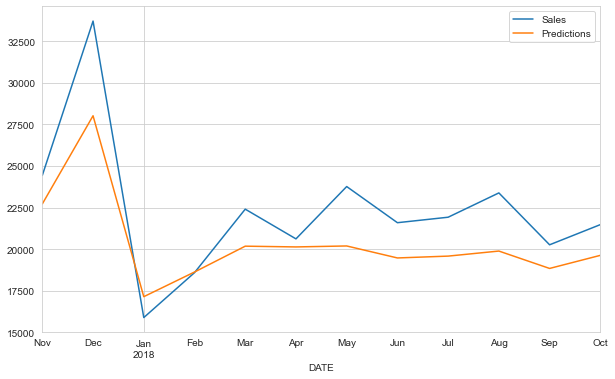

In [45]:
compare.plot()

We got the same score as above with unscaled data and unscaled prediction (mae: an error of 2099 dollars was made):

In [46]:
eval_metrics(compare.Sales, compare.Predictions)

r2_score: 0.5902700469622877 
mae: 2185.512304882211 
mse: 6884540.8577169925 
rmse: 2623.8408598306783


## Retrain and Forecasting

After installing and testing the model, we will train all our data and forecast forward. This time we will not have data for comparison.

In [47]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

We scaled all the data and gave it to the TimeseriesGenerator to produce a data for training:

In [48]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

df length 334, generator length 334-12=322

In [49]:
len(df)

334

In [50]:
len(generator)

322

Since we do not have validation data, we did not put an Early Stop. We set up our model as above without making any changes:

In [51]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
322/322 [==============================] - 10s 16ms/step - loss: 0.0229
Epoch 2/15
322/322 [==============================] - 5s 15ms/step - loss: 0.0199
Epoch 3/15
322/322 [==============================] - 5s 15ms/step - loss: 0.0182
Epoch 4/15
322/322 [==============================] - 5s 16ms/step - loss: 0.0184
Epoch 5/15
322/322 [==============================] - 5s 15ms/step - loss: 0.0164
Epoch 6/15
322/322 [==============================] - 5s 15ms/step - loss: 0.0150
Epoch 7/15
322/322 [==============================] - 6s 18ms/step - loss: 0.0157
Epoch 8/15
322/322 [==============================] - 5s 16ms/step - loss: 0.0140
Epoch 9/15
322/322 [==============================] - 5s 15ms/step - loss: 0.0122
Epoch 10/15
322/322 [==============================] - 5s 15ms/step - loss: 0.0110
Epoch 11/15
322/322 [==============================] - 5s 16ms/step - loss: 0.0090
Epoch 12/15
322/322 [==============================] - 5s 15ms/step - loss: 0.0066
Epoch 13/15


In [53]:
scaled_full_data.shape

(334, 1)

In [54]:
scaled_full_data[-length:].shape

(12, 1)

In the previous forecast process, we took the last 12 data of the train data and made the forecast process, now we will perform the forecast process by taking the last 12 data of the whole data:

In [55]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

1/1 [==============================] - 0s 22ms/step


In [56]:
forecast = scaler.inverse_transform(forecast)

In [57]:
forecast

array([[27202.59885931],
       [30660.09879827],
       [18492.88840866],
       [20921.31132746],
       [23432.89710951],
       [23262.86759424],
       [23674.33948088],
       [22404.67708302],
       [22851.71256542],
       [23148.52132511],
       [21825.93217993],
       [24050.69925308]])

In [58]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


We will combine real data with our forecast forecasts. The last data in our data was ending on 2019-10-01. Our forecast values should start from the next month 2019-11-01 and continue for 12 months. We need to index the forecasts according to these dates. We used the __date_range__ function for this. We gave the start time to this function and asked it to perform this operation as long as the length (12). We set the frequency as "MS" which means month (MS --> means first days of the month):

In [59]:
forecast_index = pd.date_range(start = '2019-11-01', periods = length, freq = 'MS')

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [61]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In the forecast array we are indexing, we have made it into a DataFrame:

In [62]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [64]:
forecast_df

,Forecast
2019-11-01,27202.599
2019-12-01,30660.099
2020-01-01,18492.888
2020-02-01,20921.311
2020-03-01,23432.897
2020-04-01,23262.868
2020-05-01,23674.339
2020-06-01,22404.677
2020-07-01,22851.713
2020-08-01,23148.521


By plotting the original df and the forecast together, we have obtained an image one after the other:

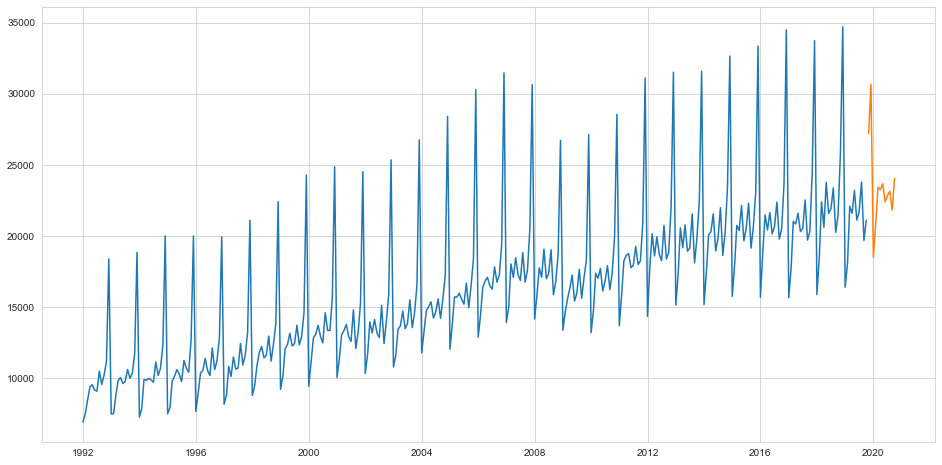

In [65]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

If we combined the two data with the concat process instead of the plot method, they would be added one after the other, but there would be no color separation between the real data and the forecast. That's why we prefer the plotting method.

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

There is an easier way to get the above chart. We plotted the larger data (df) than the other and assigned it to a variable. Then we plotted forecast_df and gave the variable into which we put df. In this way, we have drawn two data consecutively:

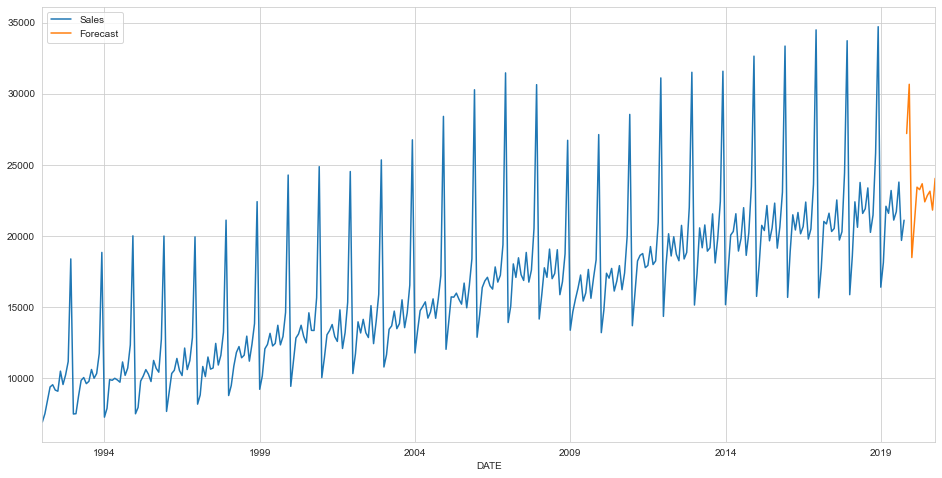

In [66]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

When we use this method, we can visualize the part we want in more detail with __len__ (This is not possible in the other method):

(576.0, 611.0)

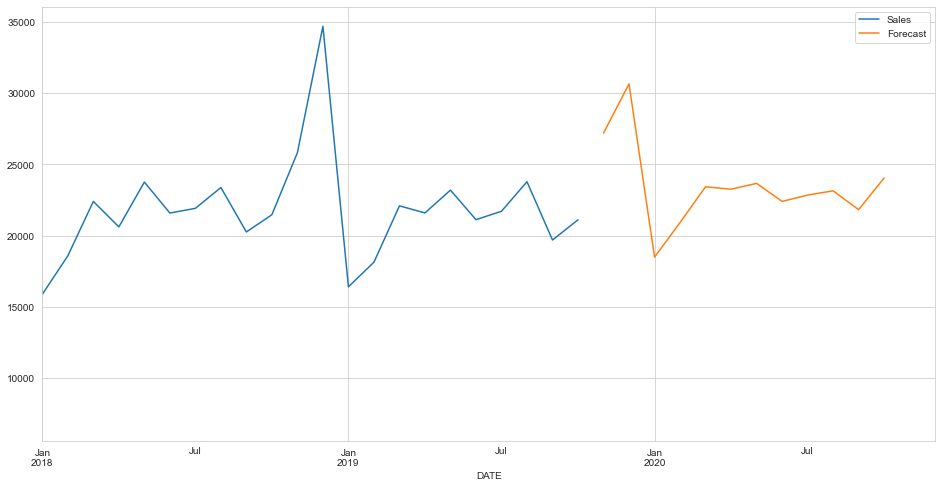

In [67]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')

Scores can also be checked by defining the ReLu activation function instead of tanh. In fact, ReLu is more consistent in the teacher's example.